In [4]:
import numpy as np
import pandas as pd
import json

In [5]:
df = pd.read_csv('training_data.csv')

out=[]

# Iterating through the columns of 
# dataframe

for column in df.columns:
    
    # Storing the rows of a column 
    # into a temporary list
    li = df[column].tolist()
    
    # appending the temporary list
    out.append(li) 
    
# Printing the final list

In [6]:
with open('data/hackathon_public.json', 'r') as f:
    data_list = json.load(f)
    

circuits = data_list['circuits']
results = data_list['results']
files = []
circ={}
families = []
for x in range(len(circuits)):
    files.append(circuits[x]['file'])
    families.append(circuits[x]['family'])


id = {cat: i for i, cat in enumerate(np.unique(families).tolist())}
file_id = {cat: i for i, cat in enumerate(np.unique(files).tolist())}
backend = {cat: i for i, cat in enumerate(['GPU', 'CPU'])}
precision = {cat: i for i, cat in enumerate(['single', 'double'])}


for x in range(len(circuits)):
    circ[x] = ([id[circuits[x]['family']], circuits[x]['n_qubits']])


y = []
new_y = []
file_forward = []
stat_x = []
for x in range(len(results)):
    if results[x]['status'] == 'ok':
        stat_x.append([file_id[results[x]['file']],backend[results[x]['backend']], precision[results[x]['precision']]])
        y.append(results[x]['forward']['threshold'])
        new_y.append(results[x]['forward']['run_wall_s'])

count = 0
for stat in stat_x:
    for file in files:
        if stat[0] == file_id[file]:
            stat.extend(circ[file_id[file]])
            count+=1

res = out
for i in range(len(res[0])):
    res[0][i] = file_id[res[0][i]]

for i in range(len(res[1])):
    res[1][i] = id[res[1][i]]

for i in range(len(res[2])):
    res[2][i] = backend[res[2][i]]

for i in range(len(res[3])):
    res[3][i] = precision[res[3][i]]

X = np.array(res).T.astype(int).tolist()
len(X)


KeyError: 'CPU'

In [10]:
def print_predictions(y_true, y_pred, n=10):
    print(" Actual\t\tPredicted\tError")
    print("-" * 40)
    for i in range(min(n, len(y_true))):
        err = y_pred[i] - y_true[i]
        print(f"{y_true[i]:.6f}\t{y_pred[i]:.6f}\t{err:+.6f}")

In [32]:
import matplotlib.pyplot as plt

def plot_percent_error_vs_actual(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    percent_error = 100 * (y_pred - y_true) / np.maximum(y_true, 1e-8)

    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, percent_error, alpha=0.4)
    plt.axhline(0, linestyle='--')
    plt.xlabel("Actual Time")
    plt.ylabel("Percentage Error (%)")
    plt.title("Percentage Error vs Actual Time")
    plt.grid(True)
    plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
np.random.seed(20)

x_train, x_test, y_train, y_test = train_test_split(
X, new_y, test_size=0.4, random_state=5
)

x_train = np.array(x_train)
y_train = np.array(y_train)



In [ ]:
rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(np.array(x_train), y_train)



,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",1000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [40]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

rf_preds = rf.predict(np.array(x_test))

r2 = r2_score(y_test, rf_preds)
mae = mean_absolute_error(y_test, rf_preds)
rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Random Forest R² : {r2:.4f}")
print(f"Random Forest MAE: {mae:.6f}")
print(f"Random Forest RMSE: {rmse:.6f}")


Random Forest R² : 0.9087
Random Forest MAE: 17.129347
Random Forest RMSE: 48.504657


In [15]:
y_train_log = np.log1p(y_train)  # log(1 + time)
y_test_log  = np.log1p(y_test)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=2,
    subsample=0.9,
    random_state=42
)

gbr.fit(np.array(x_train), np.array(y_train_log))

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.03
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",1000
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.9
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",2
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in thelef

In [17]:
gbr_preds = gbr.predict(np.array(x_test))

r2 = r2_score(y_test, np.expm1(gbr_preds))
mae = mean_absolute_error(y_test, np.expm1(gbr_preds))
rmse = np.sqrt(mean_squared_error(y_test, np.expm1(gbr_preds)))

print(f"GBR R²  : {r2:.4f}")
print(f"GBR MAE : {mae:.6f}")
print(f"GBR RMSE: {rmse:.6f}")

GBR R²  : 0.9066
GBR MAE : 13.422134
GBR RMSE: 49.044436


In [18]:
print_predictions(y_test, np.expm1(gbr_preds), n=10)

 Actual		Predicted	Error
----------------------------------------
0.991824	1.749867	+0.758043
508.986028	307.442036	-201.543992
78.027958	77.165828	-0.862130
6.279502	6.538032	+0.258530
1.138717	2.038197	+0.899480
225.970157	248.237015	+22.266857
4.071834	4.510081	+0.438247
27.040458	27.690726	+0.650268
8.433105	8.209395	-0.223709
219.186942	229.550840	+10.363898


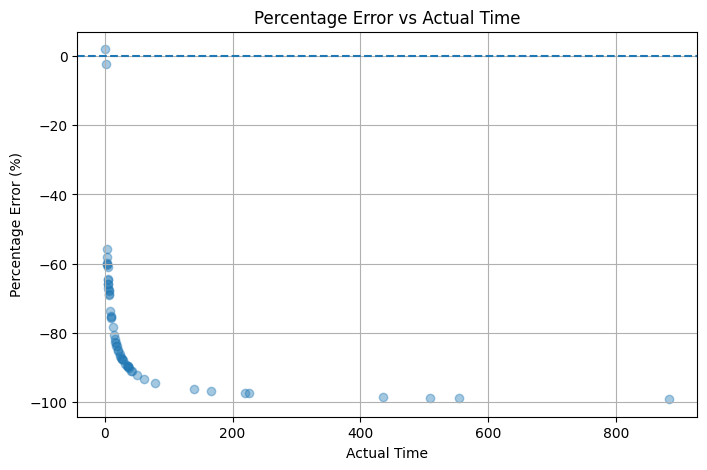

In [19]:
plot_percent_error_vs_actual(y_test, gbr_preds)

In [21]:
import numpy as np
from xgboost import XGBRegressor

x_train_np = np.array(x_train)
x_test_np  = np.array(x_test)
y_train_np = np.array(y_train_log)
y_test_np  = np.array(y_test)

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.07,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(x_train_np, y_train_np)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [22]:
xgb_preds = xgb.predict(x_test_np)
r2 = r2_score(y_test_np, np.expm1(xgb_preds))
mae = mean_absolute_error(y_test_np, np.expm1(xgb_preds))
rmse = np.sqrt(mean_squared_error(y_test_np, np.expm1(xgb_preds)))

print(f"XGB R²   : {r2:.4f}")
print(f"XGB MAE  : {mae:.6f}")
print(f"XGB RMSE : {rmse:.6f}")

XGB R²   : 0.9313
XGB MAE  : 13.667533
XGB RMSE : 42.068031


In [24]:
print_predictions(y_test, np.expm1(xgb_preds), n=10)

 Actual		Predicted	Error
----------------------------------------
0.991824	1.942627	+0.950803
508.986028	382.180023	-126.806000
78.027958	88.588661	+10.560707
6.279502	6.531344	+0.251842
1.138717	2.296694	+1.157977
225.970157	183.007111	-42.963043
4.071834	4.397602	+0.325768
27.040458	29.812063	+2.771605
8.433105	8.208165	-0.224939
219.186942	201.052292	-18.134644


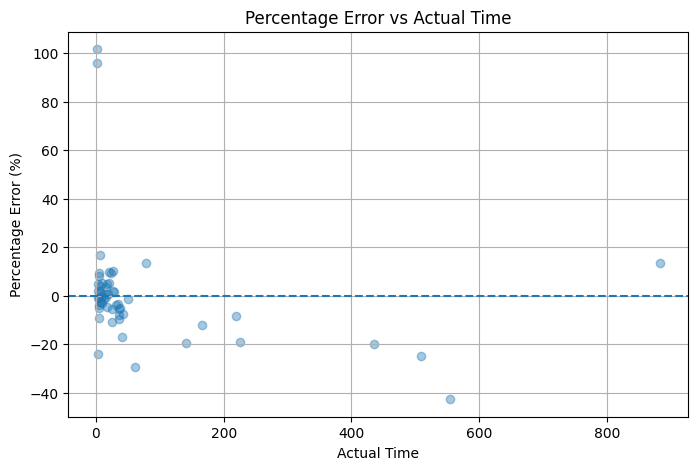

In [25]:
plot_percent_error_vs_actual(y_test, np.expm1(xgb_preds))

In [26]:
to_file = {v: k for k, v in file_id.items()}

df_gbr = pd.DataFrame({
    "actual": y_test,
    "predicted": np.expm1(gbr_preds),
    "circuit": x_test_np[:, 0]
})

df_xgb = pd.DataFrame({
    "actual": y_test,
    "predicted": np.expm1(xgb_preds),
    "circuit": x_test_np[:, 0]
})

df_gbr["circuit_name"] = df_gbr["circuit"].map(to_file)
df_xgb["circuit_name"] = df_xgb["circuit"].map(to_file)

df_gbr["percent_error"] = 100 * (df_gbr["predicted"] - df_gbr["actual"]) / np.maximum(df_gbr["actual"], 1e-8)

df_gbr["percent_error"] = 100 * (df_gbr["predicted"] - df_gbr["actual"]) / np.maximum(df_gbr["actual"], 1e-8)

df_xgb["percent_error"] = 100 * (df_xgb["predicted"] - df_xgb["actual"]) / np.maximum(df_xgb["actual"], 1e-8)

df_xgb["percent_error"] = 100 * (df_xgb["predicted"] - df_xgb["actual"]) / np.maximum(df_xgb["actual"], 1e-8)



In [27]:
import altair as alt

base_plot = alt.Chart(df_gbr).mark_circle(size=40, opacity=0.4).encode(
    x=alt.X("actual:Q", title="Actual Time"),
    y=alt.Y("percent_error:Q", title="Percentage Error (%)"),
    tooltip=["actual", "predicted", "percent_error", "circuit_name"]
).properties(
    width=350,
    height=300,
    title="GBR Percentage Error vs Actual Time"
)

zero_line = alt.Chart(pd.DataFrame({"y": [0]})).mark_rule(
    strokeDash=[4,4]
).encode(
    y="y:Q"
)

chart = base_plot + zero_line


In [28]:


base_plot = alt.Chart(df_xgb).mark_circle(size=40, opacity=0.4).encode(
    x=alt.X("actual:Q", title="Actual Time"),
    y=alt.Y("percent_error:Q", title="Percentage Error (%)"),
    tooltip=["actual", "predicted", "percent_error", "circuit_name"]
).properties(
    width=350,
    height=300,
    title="XGB Percentage Error vs Actual Time"
)

zero_line = alt.Chart(pd.DataFrame({"y": [0]})).mark_rule(
    strokeDash=[4,4]
).encode(
    y="y:Q"
)

chart2 = base_plot + zero_line

chart | chart2


alt.HConcatChart(...)

In [29]:
df_gerr = pd.DataFrame({
    "actual": y_test,
    "predicted": np.expm1(gbr_preds),
    "circuit": x_test_np[:, 0]
})

df_xerr = pd.DataFrame({
    "actual": y_test,
    "predicted": np.expm1(xgb_preds),
    "circuit": x_test_np[:, 0]
})


df_gerr["circuit_name"] = df_gbr["circuit"].map(to_file)
df_xerr["circuit_name"] = df_xgb["circuit"].map(to_file)

df_gerr["error"] = df_gerr["predicted"] - df_gerr["actual"]
df_xerr["error"] = df_xerr["predicted"] - df_xerr["actual"]




In [30]:

base_plot = alt.Chart(df_gerr).mark_circle(size=40, opacity=0.4).encode(
    x=alt.X("actual:Q", title="Actual Time"),
    y=alt.Y("error:Q", title="Error (%)"),
    tooltip=["actual", "predicted", "error", "circuit_name"]
).properties(
    width=350,
    height=300,
    title="GBR Error vs Actual Time"
)

zero_line = alt.Chart(pd.DataFrame({"y": [0]})).mark_rule(
    strokeDash=[4,4]
).encode(
    y="y:Q"
)

chart = base_plot + zero_line


In [31]:
base_plot = alt.Chart(df_xerr).mark_circle(size=40, opacity=0.4).encode(
    x=alt.X("actual:Q", title="Actual Time"),
    y=alt.Y("error:Q", title="Error (%)"),
    tooltip=["actual", "predicted", "error", "circuit_name"]
).properties(
    width=350,
    height=300,
    title="XGB Error vs Actual Time"
)

zero_line = alt.Chart(pd.DataFrame({"y": [0]})).mark_rule(
    strokeDash=[4,4]
).encode(
    y="y:Q"
)

chart2 = base_plot + zero_line

chart | chart2


alt.HConcatChart(...)

HIRAM MODELS NEW CODE

In [56]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def report_regression(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} R²  : {r2:.4f}")
    print(f"{name} MAE : {mae:.6f}")
    print(f"{name} RMSE: {rmse:.6f}")
    return r2, mae, rmse


In [57]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(
    n_estimators=2000,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

etr.fit(np.array(x_train), y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",2000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the

In [58]:
etr_preds = etr.predict(np.array(x_test))
report_regression("ExtraTrees", y_test, etr_preds)


ExtraTrees R²  : 0.9348
ExtraTrees MAE : 13.112115
ExtraTrees RMSE: 40.979093


(0.9348081829529586, 13.112114858326942, np.float64(40.979093433674045))

In [59]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor(
    loss="absolute_error",      # try also: "squared_error"
    learning_rate=0.05,
    max_depth=6,
    max_iter=2000,
    random_state=42
)

hgbr.fit(np.array(x_train), y_train)


,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'absolute_error'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",None
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.05
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",2000
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",31
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",6
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 

In [60]:
hgbr_preds = hgbr.predict(np.array(x_test))
report_regression("HGBR", y_test, hgbr_preds)


HGBR R²  : 0.3688
HGBR MAE : 39.010866
HGBR RMSE: 127.507013


(0.3688442578634751, 39.01086586740344, np.float64(127.50701307631887))

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

svr = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(C=40, epsilon=0.05, gamma="scale", kernel="rbf"))
])

svr.fit(np.array(x_train), y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('svr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm.If none is given, 'rbf' will be used. If a callable is given it isused to precompute the kernel matrix.For an intuitive visualization of different kernel typessee :ref:`sphx_glr_auto_examples_svm_plot_svm_regression.py`",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0


In [62]:
svr_preds = svr.predict(np.array(x_test))
report_regression("SVR(RBF)", y_test, svr_preds)


SVR(RBF) R²  : 0.4115
SVR(RBF) MAE : 49.015532
SVR(RBF) RMSE: 123.118846


(0.4115393000184886, 49.01553180693489, np.float64(123.11884579160728))

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=7, weights="distance"))
])

knn.fit(np.array(x_train), y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('knn', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",7
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Uniform weights are used by default.See the following example for a demonstration of the impact ofdifferent weighting schemes on predictions::ref:`sphx_glr_auto_examples_neighbors_plot_regression.py`.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value d

In [64]:
knn_preds = knn.predict(np.array(x_test))
report_regression("KNN", y_test, knn_preds)


KNN R²  : 0.2904
KNN MAE : 52.495133
KNN RMSE: 135.197416


(0.2904137802427391, 52.495132577525716, np.float64(135.19741561011682))

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

ridge.fit(np.array(x_train), y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('ridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None


In [66]:
ridge_preds = ridge.predict(np.array(x_test))
report_regression("Ridge", y_test, ridge_preds)


Ridge R²  : 0.9649
Ridge MAE : 12.596211
Ridge RMSE: 30.048912


(0.9649469420484726, 12.596211184561893, np.float64(30.04891248432242))

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(256, 128, 64),
        activation="relu",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=2000,
        random_state=42
    ))
])

mlp.fit(np.array(x_train), y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('mlp', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"loss loss: {'squared_error', 'poisson'}, default='squared_error'The loss function to use when training the weights. Note that the""squared error"" and ""poisson"" losses actually implement""half squares error"" and ""half poisson deviance"" to simplify thecomputation of the gradient. Furthermore, the ""poisson"" loss internally usesa log-link (exponential as the output activation function) and requires``y >= 0``... versionchanged:: 1.7 Added parameter `loss` and option 'poisson'.",'squared_error'
,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(256, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_t

In [68]:
mlp_preds = mlp.predict(np.array(x_test))
report_regression("MLP", y_test, mlp_preds)


MLP R²  : -0.2062
MLP MAE : 56.723233
MLP RMSE: 176.268311


(-0.20619321293462267, 56.7232333576004, np.float64(176.26831120758067))

In [69]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeCV

stack = StackingRegressor(
    estimators=[
        ("rf", RandomForestRegressor(n_estimators=1200, random_state=42, n_jobs=-1)),
        ("etr", ExtraTreesRegressor(n_estimators=1500, random_state=42, n_jobs=-1)),
        ("hgb", HistGradientBoostingRegressor(max_depth=6, learning_rate=0.05, max_iter=1500, random_state=42)),
    ],
    final_estimator=RidgeCV(alphas=np.logspace(-4, 4, 25)),
    passthrough=True,
    n_jobs=-1
)

stack.fit(np.array(x_train), y_train)


,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.","[('rf', ...), ('etr', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA regressor which will be used to combine the base estimators.The default regressor is a :class:`~sklearn.linear_model.RidgeCV`.",RidgeCV(alpha...0000000e+04]))
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",-1
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",True
,"verbose verbose: int, default=0Verbosity level.",0
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",1200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then conside

In [70]:
stack_preds = stack.predict(np.array(x_test))
report_regression("Stacking", y_test, stack_preds)


Stacking R²  : 1.0000
Stacking MAE : 0.377877
Stacking RMSE: 0.449346


(0.9999921615588937, 0.37787677421591825, np.float64(0.449345765355298))

In [73]:
import numpy as np
import optuna

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

# Asegura arrays
X_train = np.array(x_train)
y_train = np.array(y_train)

def objective(trial):
    # Hiperparametros a tunear
    alpha = trial.suggest_float("alpha", 1e-6, 1e3, log=True)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    solver = trial.suggest_categorical(
        "solver",
        ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
    )

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(
            alpha=alpha,
            fit_intercept=fit_intercept,
            solver=solver,
            random_state=42
        ))
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Optuna maximiza el promedio de R2 en CV
    scores = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1
    )
    return float(np.mean(scores))

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=80, show_progress_bar=False)

print("Best CV R2:", study.best_value)
print("Best params:", study.best_params)

# Entrena el mejor modelo en todo el train y evalua en test
best = study.best_params

best_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(
        alpha=best["alpha"],
        fit_intercept=best["fit_intercept"],
        solver=best["solver"],
        random_state=42
    ))
])

best_ridge.fit(np.array(x_train), y_train)
ridge_preds = best_ridge.predict(np.array(x_test))

report_regression("Ridge (Optuna)", y_test, ridge_preds)


c:\Users\Hiram\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-01-31 16:55:15,994] A new study created in memory with name: no-name-694d5b48-e778-4d77-9fbb-bef0480c3507
[I 2026-01-31 16:55:17,425] Trial 0 finished with value: 0.9998286175997496 and parameters: {'alpha': 0.002348881295853313, 'fit_intercept': True, 'solver': 'sparse_cg'}. Best is trial 0 with value: 0.9998286175997496.
[I 2026-01-31 16:55:18,502] Trial 1 finished with value: 0.9996273204128707 and parameters: {'alpha': 1.5320059381854048e-06, 'fit_intercept': True, 'solver': 'sparse_cg'}. Best is trial 0 with value: 0.9998286175997496.
[I 2026-01-31 16:55:19,571] Trial 2 finished with value: -4.826174914047195 and parameters: {'alpha': 0.321126430944175, 'fit_intercept': False, 'solver': 'cholesky'}. 

Best CV R2: 0.9999062112645245
Best params: {'alpha': 0.0106950716648307, 'fit_intercept': True, 'solver': 'cholesky'}
Ridge (Optuna) R²  : 1.0000
Ridge (Optuna) MAE : 0.424635
Ridge (Optuna) RMSE: 0.562859


(0.9999877010803364, 0.4246346178571922, np.float64(0.5628585736304832))